# Feature Extraction

The images that are to be classified have a fixed size of 128x32 pixels and contain for numbers, each number has a fixed size of 32x32 pixels. The alphanumerical part of the zip code is already extracted.

## Imports

In [1]:
from SimpleCV import *
from SimpleCV import Color, Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

disp = Display(displaytype='notebook')

## Seperating the numbers


### Transform the numbers
Using binarization, erosion and dilation to be able to extract the numbers as good as possible.

To find the right combination we tried the following variations:
    - test_img1.binarize()
To give all the numbers the same appearance (black and white). It makes alle the numbers look even, there is no difference in  brightness, contrast or hue anymore per image/number.

    - test_img1.binarize().dilate()
Some numbers are quite thin or are not complete (lines are broken), dilation ensures that the lines will be thickened. Which decreases the risk of broken lines, but increases the risk of the numbers becoming to thick to read (makes it harder to differentiate the shape to a number). 

    - test_img1.binarize().erode()
Some numbers are to thick or have bulges. Erosion slims the thick lines and removes most of the bulges. This increases the readability of the numbers if numbers were thicker but decrease the readability of the numbers if these were already thin (gaps might appear).

    - test_img1.binarize().erode().dilate()
Using the sequence binarize, erode and dilate leads to numbers being the right thickness, but some numberes still contain broken lines. Numbers with holes (like the number eight) are more prone to broken lines. 


The combination that worked best is: 
    - test_img1.binarize().dilate().erode()
Using the sequence binarize, dilate and erode leads to the numbers being the most readable. There are as little as possible broken lines and the lines have a nice thickness. 

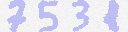

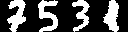

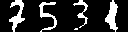

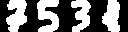

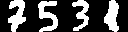

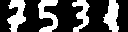

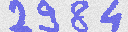

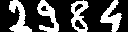

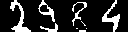

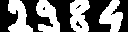

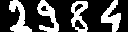

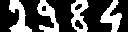

In [2]:
test_img1 = Image("../dataset-images/7531.png")

test_img1.save(disp)
test_img1.binarize().save(disp)
test_img1.binarize().erode().save(disp)
test_img1.binarize().dilate().save(disp)
test_img1.binarize().erode().dilate().save(disp)
test_img1.binarize().dilate().erode().save(disp)

test_img2 = Image("../dataset-images/2984.png")

test_img2.save(disp)
test_img2.binarize().save(disp)
test_img2.binarize().erode().save(disp)
test_img2.binarize().dilate().save(disp)
test_img2.binarize().erode().dilate().save(disp)
test_img2.binarize().dilate().erode().save(disp)

### Filename extraction
The filename of the image contains the numbers that are presented in the image. Therefore we need to strip the filename, so that only the numbers remain. 

The filename must be exracted in the same cell as that the image is read into. Once the image is passed on via a variable to a new cell, the filename consists of the filelocation in Jupyter memory. 

In [3]:
def process_image(image, filename):
    processed_filename = filename.strip('../dataset-images/').rstrip('.png')
    processed_image = image.binarize().dilate().erode()
    
    return processed_image, processed_filename

### Number extraction

Individualize the numbers by dividing the initial image (128x32 px) in four equal pieces of 32x32 px. The label for the numbers are connected as well.

At every 32 pixels at the x position in the image there is a new number. We are individualizing the number by cropping it out of the image.

In [4]:
def individual_numbers(filename, image):
    numbers = []
    xpos = 0
    for char in filename:
        crop = image.crop(xpos, 0, 32, 32, centered=False)
#         crop.save(disp)
        xpos += 32
        
        number = [char, crop, filename]
        numbers.append(number)
        
    return numbers

# Dataset 1: vision based
The first dataset will be created on the basis of vision based features.

The seven features chosen are:
- witdh
- height
- aspect ratio
- area
- amount of holes
- angle
- radius
- contour
- hull radius

### Extract blobs
By extracting the blobs from the individual numbers we are able to gather information from the number itsself only. Using the findBlobs() method on the individulaized numbers. The only blob that is found is the number itsself.

#### Simple CV own methods
SimpleCV contains some methods to get information from a blob: width, height, area, angel, radius, contour.

#### Amount of holes
To be able to get the amount of holes within a number we had to create a method of our own. 

First, we invert the color and embiggen the number image, so that a border is created around the number and the image colors are inverted. 

Next we can use findBlobs() on the inverted image. We will find at least 1 blob (the outside of the number), and more if the number contains holes (6, 8, 9, 0, (4 sometimes)).

Discard the outside of the number, because all numbers have this in common, it doesn't contribute to distinguish the numbers.

We can distuinguish the blobs by area size. 3721 is the smallest area size for the outside blob. The smaller area sizes are the actual holes within a number.


In [5]:
def get_amount_of_holes(image):
    inverted = image.embiggen(2).invert()
    
    holes = 0
    inv_blobs = inverted.findBlobs()
    for blob in inv_blobs:
        if blob.area() < 3721:
            holes += 1
    return(holes)

In [6]:
def get_blobs_from_number(number):
#     number[1] contains the image of the individual number
    blobs = number[1].findBlobs()
    
    number.append(get_amount_of_holes(number[1]))
                  
    for blob in blobs:
        number.append(blob.width())
        number.append(blob.height())
        number.append(blob.aspectRatio())
        number.append(float(blob.area()))
        number.append(blob.angle())
        number.append(blob.radius())
        number.append(len(blob.contour()))
        number.append(blob.hullRadius())
        
    return number

# Sample output
By running the code below you will see the data that is generated for one serie of postalcode numbers.

Processing the image will result in a binarized, dilated and eroded image and the corresponding stripped filename.

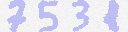

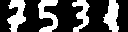

7531


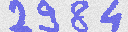

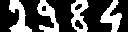

2984


In [7]:
test_img1 = Image("../dataset-images/7531.png")
test_img2 = Image("../dataset-images/2984.png")

processed_img1, filename1 = process_image(test_img1, test_img1.filename)
processed_img2, filename2 = process_image(test_img2, test_img2.filename)

test_img1.save(disp)
processed_img1.save(disp)
print(filename1)

test_img2.save(disp)
processed_img2.save(disp)
print(filename2)

Seperate the postalcode to individual numbers. 

The output for all the numbers in the postal code is:

label, individual number image, filename

In [8]:
numbers = individual_numbers(filename2, processed_img2)
print(numbers)

[['2', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce5545f0)>, '2984'], ['9', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce5549e0)>, '2984'], ['8', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce554a28)>, '2984'], ['4', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce554950)>, '2984']]


Extract all the features from the numbers.

The output for all the numbers in the postal code with features is:

label, individual number image, filename, number of holes, width, height, aspectRatio, area, angle, radius, contour, hullRadius.

In [9]:
for number in numbers:
    number_w_features = get_blobs_from_number(number)
    print(number_w_features)

['2', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce5545f0)>, '2984', 0, 22, 30, 0.7241379310344828, 279.0, 90.0, 10.489068910015272, 42, 14.429263037166306]
['9', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce5549e0)>, '2984', 1, 22, 30, 0.6286200765162219, 280.0, 83.99099445343018, 10.680607099473749, 46, 13.77413091409462]
['8', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce554a28)>, '2984', 2, 18, 30, 0.5862068965517241, 340.0, 90.0, 10.333892846225941, 38, 14.317962160249719]
['4', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce554950)>, '2984', 0, 22, 30, 1.2611941169114915, 268.0, -51.34019470214844, 9.790972120199077, 51, 12.556052824554959]


The data for all the numbers of a postalcode looks like:

In [10]:
print(numbers)

[['2', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce5545f0)>, '2984', 0, 22, 30, 0.7241379310344828, 279.0, 90.0, 10.489068910015272, 42, 14.429263037166306], ['9', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce5549e0)>, '2984', 1, 22, 30, 0.6286200765162219, 280.0, 83.99099445343018, 10.680607099473749, 46, 13.77413091409462], ['8', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce554a28)>, '2984', 2, 18, 30, 0.5862068965517241, 340.0, 90.0, 10.333892846225941, 38, 14.317962160249719], ['4', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce554950)>, '2984', 0, 22, 30, 1.2611941169114915, 268.0, -51.34019470214844, 9.790972120199077, 51, 12.556052824554959]]


# Prepare the feature data
Since we do not need the individual number image in the dataset, it is going to be deleted form the array.

In [11]:
def remove_img_from_data(number):
    del number[1]

Above we have created and explained all the parts for the following method: individual_numbers_with_features(). It is an combination of:
- individual_numbers(numbers)
- get_blobs_from_number(number)
- remove_img_from_data(number)

In [12]:
def individual_numbers_with_vision_features(filename, image):
    numbers = []
    xpos = 0
    for char in filename:
        crop = image.crop(xpos, 0, 32, 32, centered=False)
#         crop.save(disp)
        xpos += 32
        number = [char, crop, filename]
        numbers.append(number)
        
        get_blobs_from_number(number)
        
        remove_img_from_data(number)
    
    return numbers

In [13]:
result = individual_numbers_with_vision_features(filename1, processed_img1)
print(result)

[['7', '7531', 0, 19, 30, 0.6206896551724138, 292.0, 90.0, 9.763018565028554, 56, 13.636211509057295], ['5', '7531', 0, 20, 30, 0.6551724137931034, 262.5, 90.0, 10.705248815558898, 46, 15.139601562229391], ['3', '7531', 0, 18, 30, 0.5840219914863184, 212.5, 87.70938992500305, 10.126949252617072, 49, 13.437598976300153], ['1', '7531', 0, 16, 30, 0.5172413793103449, 277.5, 90.0, 10.000944603899285, 41, 13.302011424040476]]


# Dataset 1 - Program to execute
Execute the program below to run the code for all postalcodes within the data-images folder.

First we read in all the images from the "dataset-images" folder.
Then we open an outputfile to write our data to and add the labels of the columns.

for every image that is retrieved from the "dataset-images" folder we process the image and its filename. Continued by retrieving the individual numbers with features. Then the feature information per number is written to the outputfile. 

Once all the images are read, processed and written to the outputfile, the outputfile is closed. 

### Build header
Build the header of the vision dataset. It contains the label, filename, number_of_holes, width, height, aspect_ratio, area, angle, radius, contour and hull_radius.

In [14]:
def build_vision_header():
    header = []
    header.append('label')
    header.append('filename')
    header.append('number_of_holes')
    header.append('width')
    header.append('height')
    header.append('aspect_ratio')
    header.append('area')
    header.append('angle')
    header.append('radius')
    header.append('contour')
    header.append('hull_radius')
    
    return header

In [15]:
def program_dataset_vision():
    img_dir = "../dataset-images/"
    extension = "*.png"

    if not img_dir:
        path = os.getcwd()
    else:
        path = img_dir
    
    directory = os.path.join(path, extension)
    files = glob.glob(directory)

    dataset_file = open("../dataset-numpy/dataset-vision.csv", "w")

    header = build_vision_header()
    
    for item in header:
        dataset_file.writelines(str(item) + ",")
    dataset_file.write('\n')

    for file in files:
        new_img = Image(file)
        time.sleep(1)
    
        processed_img, processed_filename = process_image(new_img, file)
    
        number_per_postal = individual_numbers_with_vision_features(processed_filename, processed_img)
    
        for number in number_per_postal:
            for item in number:
                dataset_file.writelines(str(item) + ",")
            dataset_file.write("\n")
    
    dataset_file.close()

In [16]:
# program_dataset_vision()

# Dataset 2: Pixel based features
The second dataset will be created on pixel based features. Using a grid layout.

### Imports

In [17]:
from SimpleCV import *
from SimpleCV import Color, Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

disp = Display(displaytype='notebook')

In [18]:
test_img1 = Image("../dataset-images/2984.png")

pixels = np.array(test_img1.getNumpy().flatten())
print(pixels)

processed_img, processed_filename = process_image(test_img1, test_img1.filename)

number_per_postal = individual_numbers(processed_filename, processed_img)

for number in number_per_postal:
    print(number)

[238 238 238 ..., 229 229 229]
['2', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce4e7488)>, '2984']
['9', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce4e71b8)>, '2984']
['8', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce4e78c0)>, '2984']
['4', <SimpleCV.Image Object size:(32, 32), filename: (None), at memory location: (0x7f61ce4e7950)>, '2984']


# Extract pixel per cell

### Pixels
Since we are using a binarized image the possible color values are 0 or 255. White pixels have a value of 255, black pixels have a value of 0. To make the pixel_array per grid_cell more readable we divide the values in the array by 255, which results in 0 for black pixels and 1 for white pixels. If we sum the pixels now, we can exactly see how many white pixels a cell contains.

In [19]:
def get_amount_white_pixel_per_number(image, grid_cell_amount, threshold):
    grid_cell_size = 32 / grid_cell_amount
    
    matrix = np.zeros((grid_cell_amount, grid_cell_amount))
    T = threshold
    
    for y in range(grid_cell_amount):
        for x in range(grid_cell_amount):
            grid_cell = image.crop(x * grid_cell_size, y * grid_cell_size, grid_cell_size, grid_cell_size)
            pixel_arr = grid_cell.getNumpy() / 255
            sum = (pixel_arr[:,:,0]).sum()
            matrix[x][y] = sum if sum > T else 0
            
    return matrix.T

In [20]:
# threshold = 5
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 8, 5)
print(image_pix)

[[  0.   0.  16.  11.   0.   0.   0.   0.]
 [  0.   9.  13.  12.   9.   0.   0.   0.]
 [  0.  10.  10.  10.  16.  10.   0.   0.]
 [  0.   0.  14.  16.  16.  12.   0.   0.]
 [  0.   0.   0.   0.   6.  14.   0.   0.]
 [  0.   0.   0.   0.   0.  14.   0.   0.]
 [  0.   0.  11.   0.   0.   8.  12.   0.]
 [  0.   0.   8.  16.  16.  16.  12.   0.]]


/usr/local/lib/python2.7/dist-packages/SimpleCV/ImageClass.py:1970: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._numpy != "":


### Threshold
The threshold is the amount of white pixels that needs to be exceeded before the sum is taken into account. This way random or divergent pixels are excluded from the pixel_weight of a grid_cell. The threshold can not be to high either, because then you are excluding to many pixels from the pixel_weight of the grid_cell.

Looking at the tests below we can conclude that '5' will be the best threshold for our case.

This since there are fewer random/divergent pixels compared to a threshold of 3 or 4 (coordinate 3,6). But there are more pixels taken in account compared to a threshold of 6 or 7 (coordinate 4,4).

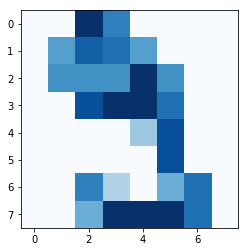

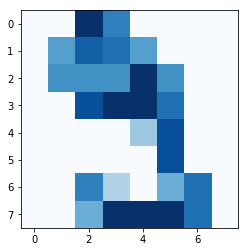

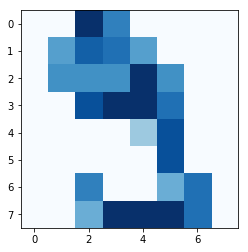

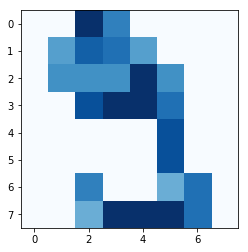

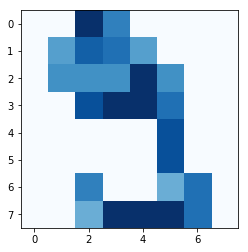

In [21]:
# threshold = 3
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 8, 3)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

# threshold = 4
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 8, 4)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

# threshold = 5
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 8, 5)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

# threshold = 6
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 8, 6)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

# threshold = 7
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 8, 7)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

### Grid size
The image of an individual number is 32px by 32px. During testing we varied between several grid_cell_amounts and found that 8 is the best amount of cells to divide the image into. It looks like a low resolution image of a number, where you can still recognize the number, but it is not overly defined.

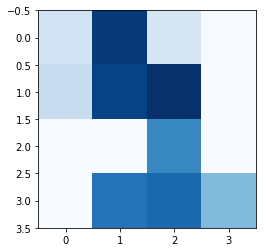

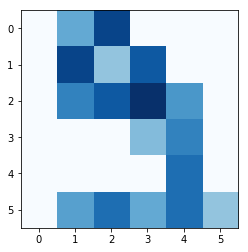

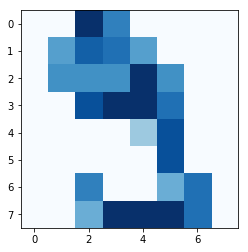

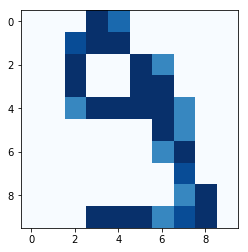

In [22]:
# grid_cell_amount = 4 
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 4, 5)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

# grid_cell_amount = 6 
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 6, 5)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

# grid_cell_amount = 8 
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 8, 5)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

# grid_cell_amount = 10 
image_pix = get_amount_white_pixel_per_number(number_per_postal[1][1], 10, 5)
plt.imshow(image_pix, cmap='Blues', interpolation='nearest')
plt.show()

## Prepare the feature data
Since we do not need the individual number image in the dataset, it is going to be deleted form the array.

In [23]:
def remove_img_from_data(number):
    del number[1]

For each cell within the grid of a number, get the whitepixel sums.

In [24]:
def white_pixel_amount_per_cell(number, grid_cell_amount):
    THRESHOLD = 5
    
    matrix = get_amount_white_pixel_per_number(number[1], grid_cell_amount, THRESHOLD)
    
    for y in range(grid_cell_amount):
        for x in range(grid_cell_amount):
            number.append(matrix[x,y])

### Features
Above we have created and explained all the parts for the following method: individual_numbers_with_pixel_features(). It is an combination of:

individual_numbers(numbers) - as seen in preparation of Dataset-vision
white_pixel_amount_per_cell(number, grid_cell_amount)
remove_img_from_data(number)


In [25]:
def individual_numbers_with_pixel_features(filename, image, grid_cell_amount):
    IMG_SIZE = 32
    numbers = []
    xpos = 0
    for char in filename:
        crop = image.crop(xpos, 0, IMG_SIZE, IMG_SIZE, centered=False)
#         crop.save(disp)
        xpos += IMG_SIZE
        number = [char, crop, filename]
        numbers.append(number)
        
        white_pixel_amount_per_cell(number, grid_cell_amount)
        
        remove_img_from_data(number)
    
    return numbers

# Dataset 2 - program to execute
Execute the program below to run the code for all postalcodes within the data-images folder.

Specify the grid_cell_amount when executing the program. This determines the gridsize.

First we read in all the images from the "dataset-images" folder. Then we open an outputfile to write our data to and add the labels of the columns.

for every image that is retrieved from the "dataset-images" folder we process the image and its filename. Continued by retrieving the individual numbers with features. Then the feature information per number is written to the outputfile.

Once all the images are read, processed and written to the outputfile, the outputfile is closed.

### Header
Build the header of the dataset. It contains the label, filename and the position of each gridcell.

In [26]:
def build_pixel_header(grid_cell_amount):
    header = []
    header.append('label')
    header.append('filename')
    
    for y in range(grid_cell_amount):
        for x in range(grid_cell_amount):
            header.append("weight" + str(x) + "_"+ str(y))
            
    return header

In [27]:
def program_dataset_pixel(grid_cell_amount):
    img_dir = "../dataset-images/"
    extension = "*.png"

    if not img_dir:
        path = os.getcwd()
    else:
        path = img_dir
    
    directory = os.path.join(path, extension)
    files = glob.glob(directory)

    dataset_file = open("../dataset-numpy/dataset-pixel" + str(grid_cell_amount) + "x" + str(grid_cell_amount) + ".csv", "w")

    for item in build_pixel_header(grid_cell_amount):
        dataset_file.writelines(str(item) + ",")
    dataset_file.write('\n')

    for file in files:
        new_img = Image(file)
        time.sleep(1)
    
        processed_img, processed_filename = process_image(new_img, file)
    
        number_per_postal = individual_numbers_with_pixel_features(processed_filename, processed_img, grid_cell_amount)
    
        for number in number_per_postal:
            for item in number:
                dataset_file.writelines(str(item) + ",")
            dataset_file.write("\n")
    
    dataset_file.close()

In [28]:
# program_dataset_pixel(4)

In [29]:
# program_dataset_pixel(8)